In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nest_asyncio
nest_asyncio.apply()
from requests_html import HTML, HTMLSession, AsyncHTMLSession
from threading import Thread
import time

In [2]:
df = pd.read_csv('/Users/cytology/Documents/code/datasets/all_english_audible.csv')
df = df[~df['asin'].isnull()]

In [3]:
total_ratings = df['rating_count'].sum()
total_ratings

64023215.0

In [4]:
df = df.sort_values('rating_count', ascending=False)
df.reset_index(inplace=True)

In [5]:
df.head()

,index,asin,author,category,length,link,narrator,price,rating,rating_count,release_date,title
0,247928,B005FRGT44,Ernest Cline,Sci-Fi & Fantasy,15 hrs and 40 mins,https://www.audible.com/pd/Ready-Player-One-Au...,Wil Wheaton,31.50,5.0,216094.0,2011-08-16,Ready Player One
1,248009,B00B5HZGUG,Andy Weir,Sci-Fi & Fantasy,10 hrs and 53 mins,https://www.audible.com/pd/The-Martian-Audiobo...,R. C. Bray,29.99,5.0,164988.0,2013-03-22,The Martian
2,142087,B00QXW5GYY,Paula Hawkins,Mysteries & Thrillers,10 hrs and 58 mins,https://www.audible.com/pd/The-Girl-on-the-Tra...,"Clare Corbett, Louise Brealey, India Fisher",28.00,4.5,133818.0,2015-01-13,The Girl on the Train
3,4895,B01IW9TQPK,Trevor Noah,Bios & Memoirs,8 hrs and 44 mins,https://www.audible.com/pd/Born-a-Crime-Audiob...,Trevor Noah,24.95,5.0,123838.0,2016-11-15,Born a Crime
4,282008,B01I28NFEE,Mark Manson,Self Development,5 hrs and 17 mins,https://www.audible.com/pd/The-Subtle-Art-of-N...,Roger Wayne,23.95,4.5,113261.0,2016-09-13,The Subtle Art of Not Giving a F*ck


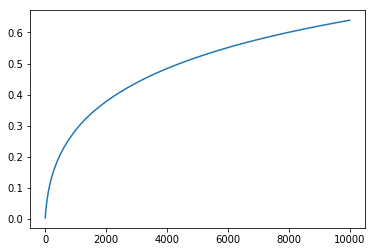

In [6]:
top_n = 10000
x = list(range(top_n))
cumsum = df.iloc[:top_n]['rating_count'].cumsum()/total_ratings
plt.plot(x, cumsum);

In [7]:
len(df)

436796

In [8]:
# cutoff_ind = cumsum[cumsum>0.8].index[0]
# df = df.iloc[:cutoff_ind]
df = df.iloc[800:820]

In [9]:
asin_list = list(df['asin'])

In [10]:
asin_list[:5]

['B00JU4QCMC', 'B073PG4DX8', 'B002VAEK76', 'B00F9F8K8K', 'B01N4S7VVP']

In [11]:
def get_overall_rating(asin, rating_dict):
    sess = HTMLSession()
    r = sess.get(f"https://www.audible.com/pd/{asin}")
    rating_dict[asin] = np.float(r.html.find('div.bc-row.bc-spacing-small', 
                                             first=False)[1].text.split(' stars ')[1][:3])
    sess.close()
    return rating_dict


def get_reviews(asin):
    baseurl = f'https://www.audible.com/pd/reviews?country=US&asin={asin}&page='
    page_num = 0
    ratings_reviews = []
    sess = HTMLSession()
    
    while True:
        try:
            url = baseurl + str(page_num)
            r = sess.get(url).html
            page_elements = r.find('div.bc-row-responsive.bc-spacing-top-medium', first=False)
            for elem in page_elements:
                review = elem.find(f'div.bc-col-responsive.USreviews{page_num}.bc-col-9', first=True).text
                ratings = [item.text[0] for item in elem.find('span.bc-text')]
                ratings_reviews.append((review, *ratings))
            page_num += 1
            
        except:
            print(page_num)
            break
    
    sess.close()
    return ratings_reviews


def get_ratings_and_reviews(asins, rating_dict, reviews):
    for asin in asins:
        rating_dict = (get_overall_rating(asin, rating_dict))
        reviews.extend(get_reviews(asin))
#         print(reviews)
    return rating_dict, reviews

In [12]:
def threaded_ratings(nthreads, asins, rating_dict=None, reviews=None):
    if rating_dict == None:
        rating_dict = {}
        
    if reviews == None:
        reviews = []
        
    threads = []
    for i in range(nthreads):
        asin_group = asins[i::nthreads]
        t = Thread(target=get_ratings_and_reviews, args=(asin_group, rating_dict, reviews))
        threads.append(t)
        
    [t.start() for t in threads]
    [t.join() for t in threads]
    
    return rating_dict, reviews

In [13]:
start = time.time()
rating_dict = {}
rating_dict, reviews = threaded_ratings(6, asin_list, rating_dict)
end = time.time()
print(end-start)

22
48
53
68
68
65
48
36
30
25
48
48
63
43
56
40
31
61
103103

110.02882790565491


In [14]:
len(reviews)

10492

In [15]:
# url = 'https://www.audible.com/pd/reviews?country=US&asin=B00JU4QCMC&page=0'
# sess = HTMLSession()
# r = sess.get(url).html
# page_elements = r.find('div.bc-row-responsive.bc-spacing-top-medium', first=False)
            

In [16]:
# page_elements

In [43]:
rev_df = pd.DataFrame(data=reviews, columns=['text', 'overall', 'performance', 'story'])

In [44]:
rev_df['overall'] = rev_df['overall'].astype(str)

In [54]:
nums = ['1','2','3','4','5']
scores = rev_df[rev_df.isin(nums)].drop('text', axis=1).dropna().astype(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1271ac208>,
      dtype=object)

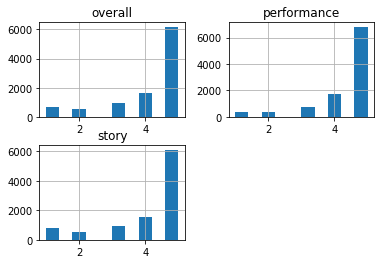

In [55]:
scores.hist()